<h2> Redes Neurais e Aprendizado Profundo <h2>

- LSTM para predições em Séries Temporais



## Parte 0 - Bibliotecas e Dataset

In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data

import matplotlib.pyplot as plt

### Dataset

O problema que você examinará nesta postagem é o problema de `previsão de passageiros` de companhias aéreas internacionais. Esse é um problema em que, dados um ano e um mês, a tarefa é prever o número de passageiros de linhas aéreas internacionais em unidades de 1.000. Os dados vão de janeiro de 1949 a dezembro de 1960, ou seja, 12 anos, com 144 observações.

In [2]:
#Realizando o download do dataset
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-09-22 10:23:57--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-09-22 10:23:57 (97.6 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [3]:
#Lendo o csv com os dados
df = pd.read_csv('airline-passengers.csv')

O dataset possui duas colunas, o mês e o número de passageiros.

In [4]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.describe

<bound method NDFrame.describe of        Month  Passengers
0    1949-01         112
1    1949-02         118
2    1949-03         132
3    1949-04         129
4    1949-05         121
..       ...         ...
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432

[144 rows x 2 columns]>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


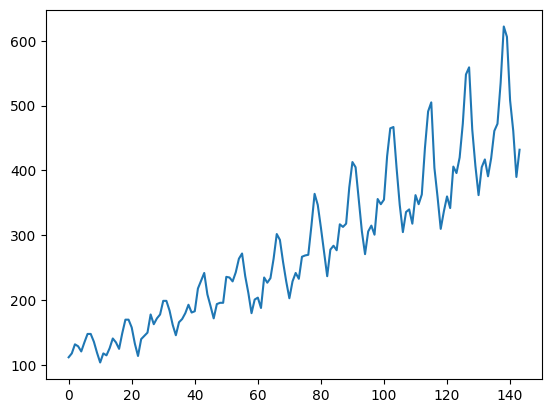

In [7]:
#Padronizando sememente aleatória
torch.manual_seed(123)

#Lendo o csv com os dados
df = pd.read_csv('airline-passengers.csv')

#Utilizando apenas a
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

#### Divisão do nosso dataset

In [8]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size

train, test = timeseries[:train_size], timeseries[train_size:]

In [9]:
def create_dataset(dataset, lookback):
    """Transformando uma série temporal em um conjunto de predição
    Args:
        dataset: Um numpy array de séries temporais, cuja primeira dimensão são as etapas de tempo
        lookback: Tamanho da janela para predição
    """

    X, y = [], []
    
    for i in range(len(dataset) - lookback):
        feature = dataset[ i : i+lookback ]
        target = dataset[ i+1 : i+lookback + 1 ]
        X.append(feature)
        y.append(target)

    return torch.tensor(X), torch.tensor(y)

In [15]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

#Apresentando o cojunto de dados
#Observe que a série temporal de entrada é uma matriz 2D e a saída da função create_dataset() será um tensor 3D.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


## Parte 1 - Construindo o nosso modelo LSTM

In [11]:
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)# batch_first=True faz com que os tensores tenham shape (batch_dim, seq_dim, feature_dim)
        self.linear = nn.Linear(50, 1)


    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)

        return x

## Parte 2 - Treinando o modelo LSTM

In [12]:
#Parâmetros
num_epochs = 2000
model = LSTM_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [13]:
#Loop de Treinamento
for epoch in range(num_epochs):
    model.train() #Rede em modo de treinamento
    for x,y in loader:
        #Forward
        preds = model(x)
        #Perdas/Loss
        loss = loss_fn(preds, y)
        #Limpeza dos gradientes
        optimizer.zero_grad()
        #Backward
        loss.backward()
        #Atualização de parâmetros
        optimizer.step()

    #Printando informações em 100 iterações
    if epoch % 100 != 0:
        continue

    #Rede em modo de avaliação
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
   
    print("Epoch: %03d | train RMSE: %.4f --- test RMSE: %.4f" % (epoch, train_rmse, test_rmse))

Epoch: 000 | train RMSE: 226.0696 --- test RMSE: 422.4716
Epoch: 100 | train RMSE: 185.5198 --- test RMSE: 380.0402
Epoch: 200 | train RMSE: 152.4817 --- test RMSE: 344.4106
Epoch: 300 | train RMSE: 124.2338 --- test RMSE: 312.3152
Epoch: 400 | train RMSE: 101.0167 --- test RMSE: 283.2139
Epoch: 500 | train RMSE: 82.7221 --- test RMSE: 257.0958
Epoch: 600 | train RMSE: 66.4232 --- test RMSE: 231.9980
Epoch: 700 | train RMSE: 53.6665 --- test RMSE: 208.9864
Epoch: 800 | train RMSE: 43.9250 --- test RMSE: 188.2516
Epoch: 900 | train RMSE: 37.6614 --- test RMSE: 170.1260
Epoch: 1000 | train RMSE: 32.6281 --- test RMSE: 154.6275
Epoch: 1100 | train RMSE: 28.8184 --- test RMSE: 141.3779
Epoch: 1200 | train RMSE: 27.1993 --- test RMSE: 130.7852
Epoch: 1300 | train RMSE: 27.7519 --- test RMSE: 124.2524
Epoch: 1400 | train RMSE: 25.1341 --- test RMSE: 116.4874
Epoch: 1500 | train RMSE: 24.2596 --- test RMSE: 111.7140
Epoch: 1600 | train RMSE: 24.5295 --- test RMSE: 107.7179
Epoch: 1700 | train

Como o conjunto de dados é pequeno, o modelo deve ser treinado por tempo suficiente para aprender sobre o padrão. 

Ao longo dessas 2.000 épocas treinadas, você pode observar a diminuição do RMSE no conjunto de treinamento e de teste.

Espera-se que o RMSE do conjunto de teste seja uma ordem de grandeza maior.

O RMSE de 100 significa que a previsão e o alvo real estariam, em média, 100 vezes fora do valor (ou seja, 100.000 passageiros nesse conjunto de dados).

## Parte 3 - Plot

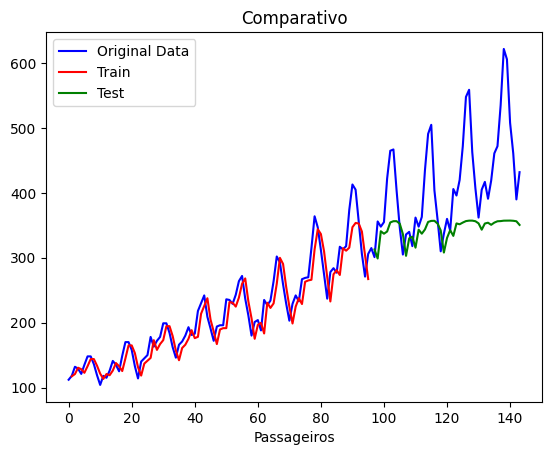

In [16]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


plt.plot(timeseries, c='b', label='Original Data')
plt.plot(train_plot, c='r', label='Train')
plt.plot(test_plot, c='g',  label='Test')

plt.title("Comparativo")
plt.xlabel("Passageiros")
plt.legend()

plt.show()

A partir do exemplo acima, você pega o resultado do modelo como `y_pred`, mas extrai somente os dados da última etapa de tempo como `y_pred[:, -1, :]`. 


Você pode perceber que o modelo pode se ajustar bem ao conjunto de treinamento, mas não muito bem ao conjunto de teste.


## Referências
- **LSTM for Time Series Prediction in PyTorch:** https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/